In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model.cnn_lstm.cnn_lstm import CNN_LSTM
from model.lstm.lstm import LSTM
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset_CNN_LSTM, TravelTimeDataset_LSTM

In [2]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'CNN_LSTM': {
        'lstm_num_layers': 1,
        'lstm_hidden_size': 200,
        'dropout': 0.7,
        'best_model_path': 'E:/checkpoints/cnn_lstm/lstm_10_0.783.pth'
    },  
    'LSTM': {
        'input_size': 1,
        'num_lstm_layers': 1,
        'lstm_size': 256,
        'dropout': 0.7,
        'best_model_path': 'E:/checkpoints/lstm/lstm_69_0.778.pth'
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/cnn_lstm',
    }
}

In [3]:
def download_data(cfg, plot):
    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)
    
    data_travel_time = [float(df.loc[df.index == date][cfg['data']['feature']]) for date in df.index]
    data_travel_time = np.array(data_travel_time)
    data_travel_time = data_travel_time.reshape(-1, 1)

    num_data_points = len(data_date)
    print(f"Number data points: {num_data_points} from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
    
    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]
        
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_travel_time, color=cfg['plots']['color_actual']) 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_travel_time, num_data_points

Number data points: 7413 from 2019-01-01 00:00:00 to 2019-12-31 20:00:00


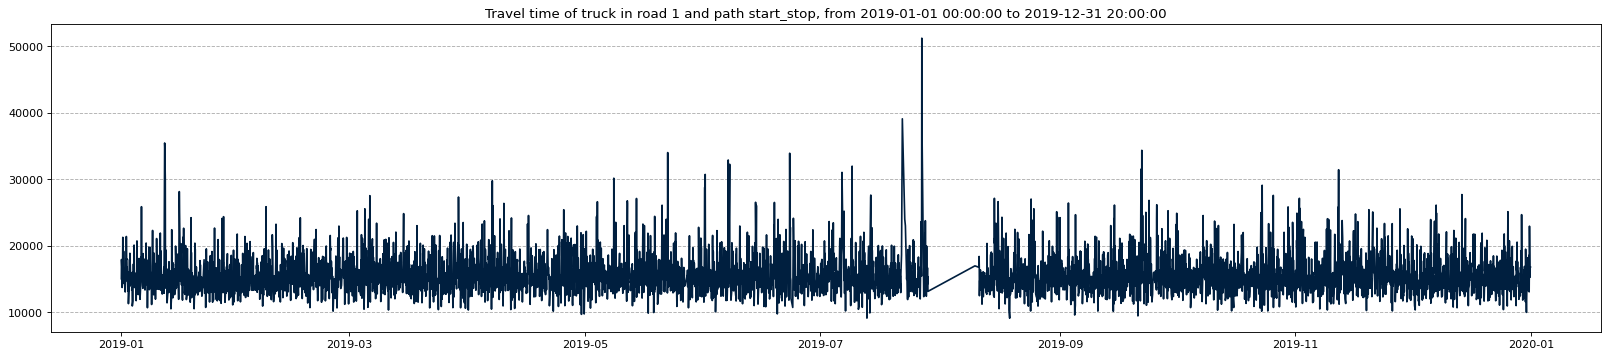

In [4]:
data_date, data_travel_time, num_data_points = download_data(cfg, cfg['plots']['show_plots'])

In [5]:
scaler = StandardScaler()
normalize_data_travel_time = scaler.fit_transform(data_travel_time)

# Data preparation: generating training, test and validation data

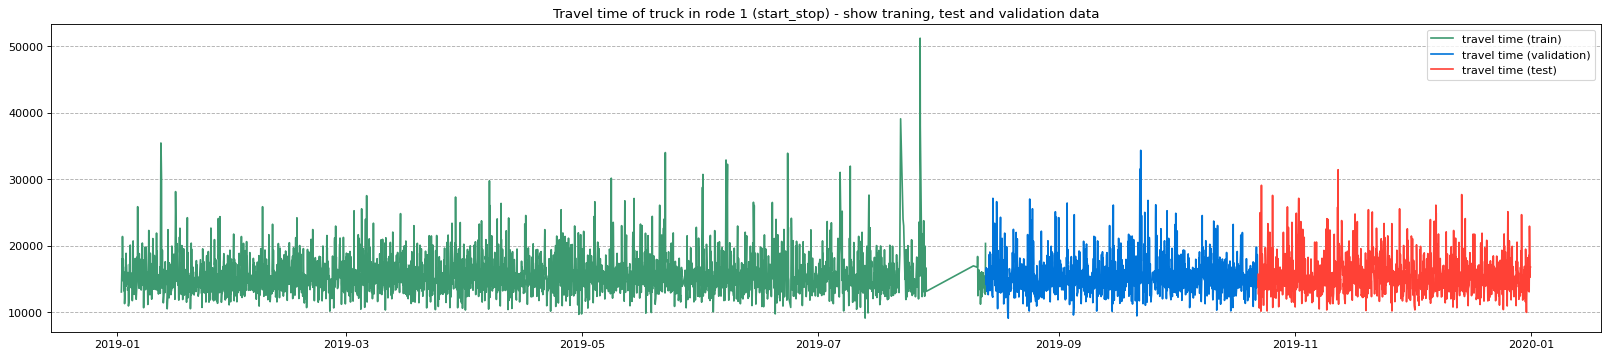

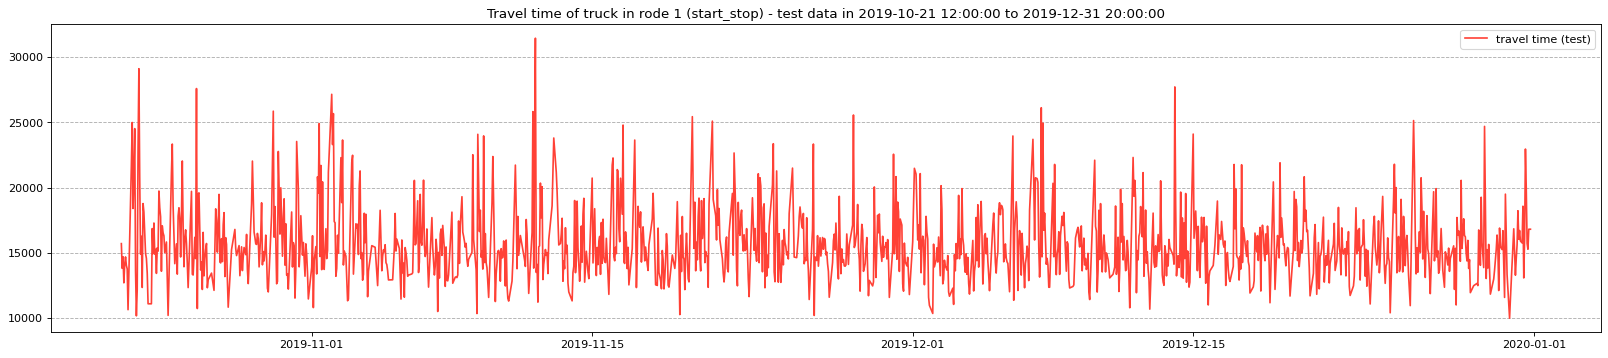

Test data shape: (1479, 21) (1479,)


In [6]:
_, _, data_x_test, _, _, data_y_test, _, split_val_index = generate_data(normalize_data_travel_time, data_date, num_data_points, scaler, cfg, True)
print(f"Test data shape: {data_x_test.shape} {data_y_test.shape}")

In [7]:
# create class dataset
dataset_test_cnn_lstm = TravelTimeDataset_CNN_LSTM(data_x_test, data_y_test)
dataset_test_lstm = TravelTimeDataset_LSTM(data_x_test, data_y_test)
print(f"Test data for model shape: {dataset_test_cnn_lstm.x.shape} {dataset_test_cnn_lstm.y.shape}")
print(f"Test data for model shape: {dataset_test_lstm.x.shape} {dataset_test_lstm.y.shape}")

Test data for model shape: (1479, 1, 21) (1479,)
Test data for model shape: (1479, 21, 1) (1479,)


In [8]:
cnn_lstm = CNN_LSTM(lstm_hidde_size=cfg['CNN_LSTM']['lstm_hidden_size'], lstm_num_layers=cfg['CNN_LSTM']['lstm_num_layers'], dropout=cfg['CNN_LSTM']['dropout'])
lstm = LSTM(input_size=cfg['LSTM']['input_size'], hidden_size=cfg['LSTM']['lstm_size'], num_layers=cfg['LSTM']['num_lstm_layers'], output_size=1, dropout=cfg['LSTM']['dropout'])
if torch.cuda.is_available():
    cfg['train']['device'] = 'cuda'
else:
    cfg['train']['device'] = 'cpu'
print(f"Training model use the {cfg['train']['device']}")
cnn_lstm = cnn_lstm.to(cfg['train']['device'])
lstm = lstm.to(cfg['train']['device'])

Training model use the cpu


In [9]:
def eval(dataset_test, split_val_index, scaler, model, cfg, best_model_path, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    mse = mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))
    rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1))))
    mae = mean_absolute_error(scaler.inverse_transform(dataset_test.y.reshape(1, -1)), scaler.inverse_transform(predicted_test.reshape(1, -1)))

    print(f"MSE : {mse}")
    print(f"RMSE : {rmse}")
    print(f"MAE : {mae}")

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = scaler.inverse_transform(dataset_test.y.reshape(-1, 1))
        to_plot_predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1))
        to_plot_data_date = data_date[split_val_index + cfg['data']['window_size']:]

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(to_plot_data_date, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(to_plot_data_date, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

MSE : 6978096.449578444
RMSE : 2641.60868592955
MAE : 1922.6153930003243


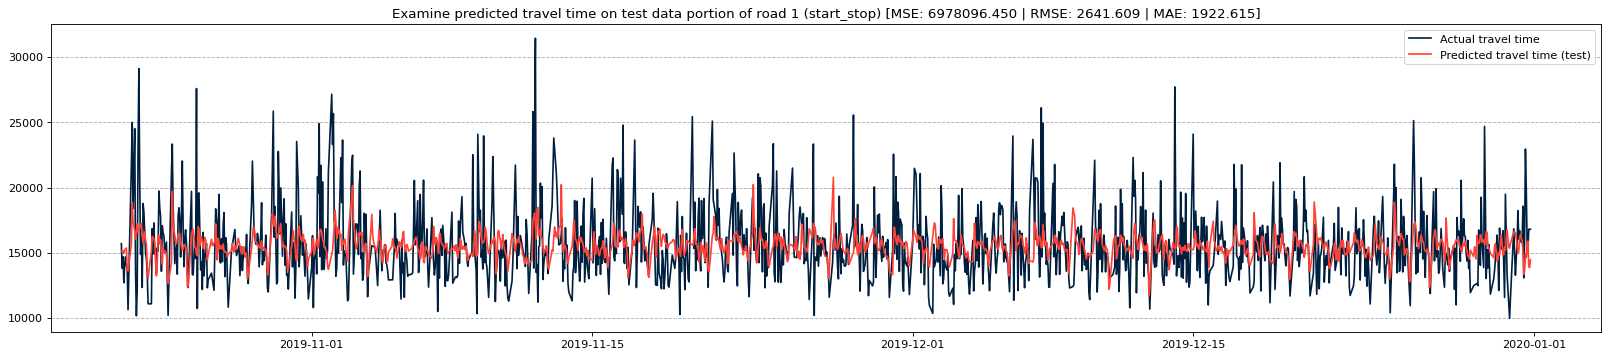

In [10]:
eval(dataset_test_cnn_lstm, split_val_index, scaler, cnn_lstm, cfg, cfg['CNN_LSTM']['best_model_path'], True)

MSE : 6896115.11051233
RMSE : 2626.0455271210226
MAE : 1912.7689624828708


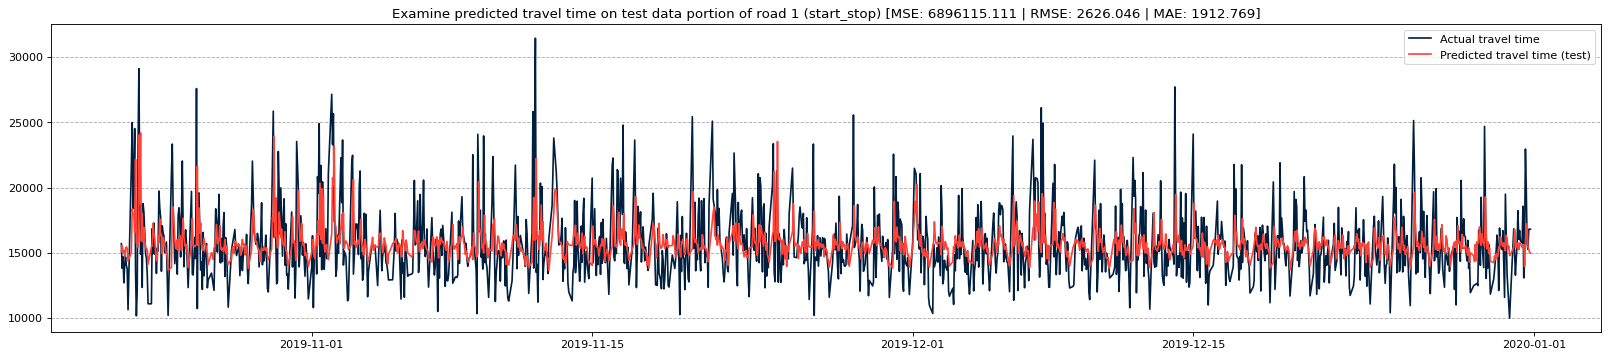

In [11]:
eval(dataset_test_lstm, split_val_index, scaler, lstm, cfg, cfg['LSTM']['best_model_path'], True)